# Sect 25-Pt 2: Intro to Logistic Regression 

- online-ds-pt-041320
- 09/02/20

## Questions?

### From Last Class/Gdoc

- I’m confused about ROC and AUC. 
    - how are the false positive or false negative percents a parameter for ROC? 
    - How do you graph one vs the other when they are fixed values?<br>I don’t think I’m understanding what’s going on under the hood with this function…


- Pseudo R-squared from Statsmodels Logit summary


- Logistic Regression in Scikit Learn  Lab: 
    - Why didnt they do the get dummies?
    - 
logreg = `LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')` 
        - why is the fit_intercept False, and why do we assign large value to C?


### Answers

#### **Pseudo R-Squared: Stack Overflow Discussion:**
> "Those unfamiliar with 𝜌2 should be forewarned that its values tend to be considerably lower than those of the 𝑅2 index...For example, values of 0.2 to 0.4 for 𝜌2 represent EXCELLENT fit."
<br><br> So basically, 𝜌2 can be interpreted like 𝑅2, but don't expect it to be as big. And values from 0.2-0.4 indicate (in McFadden's words) excellent model fit."
- Source: https://stats.stackexchange.com/questions/82105/mcfaddens-pseudo-r2-interpretation
    
    

#### Scikit Learn Logistic Regression parameters:
- From the docstring for LogsisticRegression,C:
```C : float, default=1.0
    Inverse of regularization strength; must be a positive float.
    Like in support vector machines, smaller values specify strong```
    
- Scikit-Learn Logistic Regression User Guide:
    - https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

## Topics in Sect 25

- Last Class:
    - Supervised vs Unsupervised Learning
    - Logistic Regression - Theory
    - Applying Logistic Regression with `statsmodels`
    - Evaluating Classifiers
        - Accuracy, Precision, Recall, F1-Score
        - Confusion Matrices


- Today:
    - Applying Logistic Regression with scikit-learn
    - Evaluating Classifiers:
        - ROC-AUC curve
    - Class Imbalance Problems

# Previously on...

## Implementing Logistic Regression

#### Predict Passenger Survival on Titanic

In [1]:
# !pip install fsds
from fsds.imports import *

fsds v0.2.23 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [2]:
df = fs.datasets.load_titanic(read_csv_kwds={'index_col':0})
relevant_columns = ['Pclass', 'Age', 'SibSp', 'Fare', 'Sex', 'Embarked', 'Survived']
df = df[relevant_columns]
df.head()

,Pclass,Age,SibSp,Fare,Sex,Embarked,Survived
0,3,22.0,1,7.2500,male,S,0
1,1,38.0,1,71.2833,female,C,1
2,3,26.0,0,7.9250,female,S,1
3,1,35.0,1,53.1000,female,S,1
4,3,35.0,0,8.0500,male,S,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    object 
 1   Age       714 non-null    float64
 2   SibSp     891 non-null    int64  
 3   Fare      891 non-null    float64
 4   Sex       891 non-null    object 
 5   Embarked  889 non-null    object 
 6   Survived  891 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 55.7+ KB


In [4]:
# Recast Number Cols
df['Pclass'] = pd.to_numeric(df['Pclass'],errors='coerce')

In [5]:
df['Survived'].value_counts(normalize=True,dropna=False)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

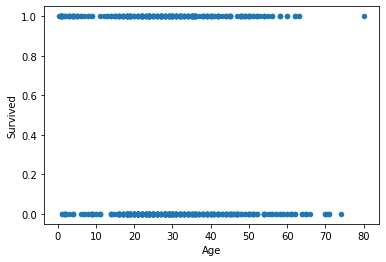

In [6]:
df.plot('Age','Survived',kind='scatter');

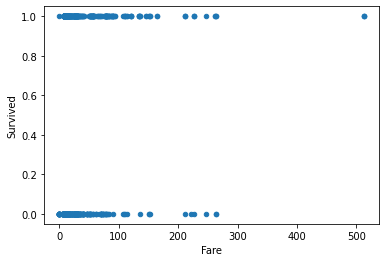

In [7]:
df.plot('Fare','Survived',kind='scatter');

### Q: What are the preprocessing steps I need to perform before I create the model?

<!-- Fill/drop in missing/null values
- Feature Selection / Feature Engineering (interaction terms)
- Handling categorial variables
    - One Hot Encoding 
    - Label Encoding
- Handling Outliers (maybe apply today)
- Normalizing/Standardizing our data

- **Multicollinearity (does it still matter as much for Logistic?)**

- Train-test-split
-->

- Train-test-split
- Address null values
- Encode categorical data
- Train Model with train data
- Evaluate Model with test data

### Preprocessing

In [8]:
## Null Values
df.isna().sum() / len(df)

Pclass      0.054994
Age         0.198653
SibSp       0.000000
Fare        0.000000
Sex         0.000000
Embarked    0.002245
Survived    0.000000
dtype: float64

In [9]:
## Separate X and y
target = 'Survived'
X = df.drop(columns=target)
y = df[target]
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [10]:
## String columns
cat_cols = df.drop(columns=target).select_dtypes('O').columns
cat_cols

Index(['Sex', 'Embarked'], dtype='object')

In [11]:
## Number cols
num_cols = df.drop(columns=target).select_dtypes('number').columns
num_cols

Index(['Pclass', 'Age', 'SibSp', 'Fare'], dtype='object')

In [12]:
## Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=221)

print(X_train.shape, y_test.shape)
pd.Series(y_train).value_counts(1)

(668, 6) (223,)


0    0.642216
1    0.357784
Name: Survived, dtype: float64

In [13]:
X_train.isna().sum()

Pclass       29
Age         136
SibSp         0
Fare          0
Sex           0
Embarked      0
dtype: int64

In [14]:
## Saving null value indices
train_nulls = X_train.isna().any(axis=1)
test_nulls = X_test.isna().any(axis=1)

In [15]:
## Dropping Nulls for time
X_train = X_train.loc[~train_nulls]
y_train = y_train.loc[~train_nulls]

X_test = X_test.loc[~test_nulls]
y_test = y_test.loc[~test_nulls]
# X_train.isna().sum()

In [16]:
X_train.isna().sum(), X_test.isna().sum()

(Pclass      0
 Age         0
 SibSp       0
 Fare        0
 Sex         0
 Embarked    0
 dtype: int64,
 Pclass      0
 Age         0
 SibSp       0
 Fare        0
 Sex         0
 Embarked    0
 dtype: int64)

In [17]:
## REMOVED FROM WORKFLOW
# from sklearn.impute import SimpleImputer
# imputer_num = SimpleImputer(strategy='median')

# X_train[num_cols] = imputer_num.fit_transform(X_train[num_cols])
# X_test[num_cols] = imputer_num.transform(X_test[num_cols])

# X_train[cat_cols] = imputer_cat.fit_transform(X_train[cat_cols])
# X_test[cat_cols] = imputer_cat.transform(X_test[cat_cols])


In [18]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False,drop='first')#,handle_unknown='ignore')


## Copy the numerical columns to new ohe X_train, X_test
X_train_ohe = X_train.drop(columns=cat_cols).copy()
X_test_ohe = X_test.drop(columns=cat_cols).copy()

## Fit the encoder
encoder.fit(X_train[cat_cols])
ohe_cols = encoder.get_feature_names(cat_cols)

## Transform X_train and X_test
X_train_ohe[ohe_cols] = encoder.transform(X_train[cat_cols])
X_test_ohe[ohe_cols] = encoder.transform(X_test[cat_cols])

X_train_ohe

,Pclass,Age,SibSp,Fare,Sex_male,Embarked_Q,Embarked_S
705,2.0,39.0,0,26.0000,1.0,0.0,1.0
559,3.0,36.0,1,17.4000,0.0,0.0,1.0
521,3.0,22.0,0,7.8958,1.0,0.0,1.0
314,2.0,43.0,1,26.2500,1.0,0.0,1.0
429,3.0,32.0,0,8.0500,1.0,0.0,1.0
...,...,...,...,...,...,...,...
483,3.0,63.0,0,9.5875,0.0,0.0,1.0
885,3.0,39.0,0,29.1250,0.0,1.0,0.0
882,3.0,22.0,0,10.5167,0.0,0.0,1.0
742,1.0,21.0,2,262.3750,0.0,0.0,0.0


In [19]:
## Scale data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler= StandardScaler()

X_train_sca = X_train_ohe.copy()
X_test_sca = X_test_ohe.copy()


X_train_sca[num_cols] = scaler.fit_transform(X_train_sca[num_cols])
X_test_sca[num_cols] = scaler.transform(X_test_sca[num_cols])

X_train_sca

,Pclass,Age,SibSp,Fare,Sex_male,Embarked_Q,Embarked_S
705,-0.280074,0.656961,-0.536520,-0.151087,1.0,0.0,1.0
559,0.922596,0.448871,0.551423,-0.332941,0.0,0.0,1.0
521,0.922596,-0.522217,-0.536520,-0.533915,1.0,0.0,1.0
314,-0.280074,0.934414,0.551423,-0.145800,1.0,0.0,1.0
429,0.922596,0.171417,-0.536520,-0.530654,1.0,0.0,1.0
...,...,...,...,...,...,...,...
483,0.922596,2.321682,-0.536520,-0.498143,0.0,0.0,1.0
885,0.922596,0.656961,-0.536520,-0.085006,0.0,1.0,0.0
882,0.922596,-0.522217,-0.536520,-0.478494,0.0,0.0,1.0
742,-1.482743,-0.591580,1.639367,4.847260,0.0,0.0,0.0


In [20]:
## Verify scaling
X_train_ohe.describe().round(2)

,Pclass,Age,SibSp,Fare,Sex_male,Embarked_Q,Embarked_S
count,511.00,511.00,511.00,511.00,511.00,511.00,511.00
mean,2.23,29.53,0.49,33.14,0.65,0.04,0.78
std,0.83,14.43,0.92,47.34,0.48,0.19,0.42
min,1.00,0.42,0.00,0.00,0.00,0.00,0.00
25%,1.00,20.00,0.00,8.05,0.00,0.00,1.00
50%,2.00,28.00,0.00,15.50,1.00,0.00,1.00
75%,3.00,38.00,1.00,33.00,1.00,0.00,1.00
max,3.00,74.00,5.00,512.33,1.00,1.00,1.00


In [21]:
X_train_sca.describe().round(2)

,Pclass,Age,SibSp,Fare,Sex_male,Embarked_Q,Embarked_S
count,511.00,511.00,511.00,511.00,511.00,511.00,511.00
mean,-0.00,-0.00,0.00,-0.00,0.65,0.04,0.78
std,1.00,1.00,1.00,1.00,0.48,0.19,0.42
min,-1.48,-2.02,-0.54,-0.70,0.00,0.00,0.00
25%,-1.48,-0.66,-0.54,-0.53,0.00,0.00,1.00
50%,-0.28,-0.11,-0.54,-0.37,1.00,0.00,1.00
75%,0.92,0.59,0.55,-0.00,1.00,0.00,1.00
max,0.92,3.08,4.90,10.13,1.00,1.00,1.00


## Fitting a Logistic Regression with `statsmodels`

In [22]:
import statsmodels.api as sm

In [23]:
y_train.value_counts()

0    321
1    190
Name: Survived, dtype: int64

In [24]:
X_train_sms = sm.add_constant(X_train_sca)
X_test_sms = sm.add_constant(X_test_sca)
X_train_sms

,const,Pclass,Age,SibSp,Fare,Sex_male,Embarked_Q,Embarked_S
705,1.0,-0.280074,0.656961,-0.536520,-0.151087,1.0,0.0,1.0
559,1.0,0.922596,0.448871,0.551423,-0.332941,0.0,0.0,1.0
521,1.0,0.922596,-0.522217,-0.536520,-0.533915,1.0,0.0,1.0
314,1.0,-0.280074,0.934414,0.551423,-0.145800,1.0,0.0,1.0
429,1.0,0.922596,0.171417,-0.536520,-0.530654,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
483,1.0,0.922596,2.321682,-0.536520,-0.498143,0.0,0.0,1.0
885,1.0,0.922596,0.656961,-0.536520,-0.085006,0.0,1.0,0.0
882,1.0,0.922596,-0.522217,-0.536520,-0.478494,0.0,0.0,1.0
742,1.0,-1.482743,-0.591580,1.639367,4.847260,0.0,0.0,0.0


In [25]:
logit = sm.Logit(y_train,X_train_sms).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.422151
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  511
Model:                          Logit   Df Residuals:                      503
Method:                           MLE   Df Model:                            7
Date:                Wed, 02 Sep 2020   Pseudo R-squ.:                  0.3603
Time:                        17:48:40   Log-Likelihood:                -215.72
converged:                       True   LL-Null:                       -337.22
Covariance Type:            nonrobust   LLR p-value:                 8.564e-49
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4746      0.329      4.475      0.000       0.829       2.120
Pclass        -1.0147      0.165     -6.148      0.000      -1.338      -0.691
Age           -0.6972      0.144     -4.854      0.000      -0.979      -0.416
SibSp         -0.2736      0.140     -1.948      0.051      -0.549       0.002
Fare          -0.0272      0.140     -0.195      0.846      -0.301       0.247
Sex_male      -2.7507      0.265    -10.399      0.000      -3.269      -2.232
Embarked_Q    -1.6988      0.793     -2.143      0.032      -3.253      -0.145
Embarked_S    -0.4827      0.322     -1.497      0.134      -1.115       0.149
==============================================================================
"""

In [26]:
from sklearn import metrics
y_hat_train = logit.predict(X_train_sms).round()
y_hat_test = logit.predict(X_test_sms).round()
display(y_hat_train.head(),y_train.head())

705    0.0
559    0.0
521    0.0
314    0.0
429    0.0
dtype: float64

705    0
559    1
521    0
314    0
429    1
Name: Survived, dtype: int64

In [27]:
def remake_df(array,df):
    """Returns the array as a df with the same columns and index as df"""
    return pd.DataFrame(array, columns=df.columns, index=df.index)


def plot_confusion_matrix(y_test,y_hat_test, normalize='true',
                          classes=['Died','Survived'],cmap='Blues',
                         style='seaborn-notebook'):
    """Plots Confusion Matrix from sklearn."""
    
    cm = metrics.confusion_matrix(y_test,y_hat_test.round(),
                                  normalize=normalize)
    
    with plt.style.context(style):
        ax = sns.heatmap(cm,annot=True,square=True, center=0,cmap=cmap,
                   xticklabels=classes,yticklabels=classes)
        
    if normalize==False:
        title = "Raw Confusion Matrix"
    else:
        title = f"Normalized Confusion Matrix\n(by {normalize} classes)"
        
    ax.set(ylabel='True Classes',xlabel='Predicted Classes',title=title)
    fig = ax.get_figure()
    
    return fig,ax


def evaluate_statsmodel(y_test,y_hat_test,classes=['Died','Survived'],
                   normalize='true',cmap='Blues'):
    """Evaluates Classification models by displaying:
    - Classification Report
    - Normalized Confusion Matrix"""
    dashes = '---'*20
    print(dashes)
    print("[i] CLASSIFICATION REPORT")
    print(dashes)
    
    print(metrics.classification_report(y_test,y_hat_test.round(),
                                        target_names=classes))
    print(dashes)
    fig,ax = plot_confusion_matrix(y_test,y_hat_test)

    
def get_model_coeffs(X_df,model, statsmodels=True):
        
    if statsmodels == False:
        coeffs_df = pd.DataFrame({'Coefficients':model.coef_[0]},index=X_df.columns)
        coeffs_df.loc['const'] = model.intercept_
        coeffs_df
        # dict(zip(X_df.col
#         coeffs_df = pd.DataFrame(coeffs,index=['Coefficents']).Tx

    else:
        coeffs_df = pd.DataFrame({
            'Coefficents':model.params,
            'p-values':model.pvalues.round(4)
        })
        
    return coeffs_df

Optimization terminated successfully.
         Current function value: 0.422151
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  511
Model:                          Logit   Df Residuals:                      503
Method:                           MLE   Df Model:                            7
Date:                Wed, 02 Sep 2020   Pseudo R-squ.:                  0.3603
Time:                        17:48:40   Log-Likelihood:                -215.72
converged:                       True   LL-Null:                       -337.22
Covariance Type:            nonrobust   LLR p-value:                 8.564e-49
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4746      0.329      4.475      0.000       0.829       2.120
Pclass        -1.0147      0.165     -6.148      0.000      -1.338      -0.691
Age           -0.6972      0.144     -4.854      0.000      -0.979      -0.416
SibSp         -0.2736      0.140     -1.948      0.051      -0.549       0.002
Fare          -0.0272      0.140     -0.195      0.846      -0.301       0.247
Sex_male      -2.7507      0.265    -10.399      0.000      -3.269      -2.232
Embarked_Q    -1.6988      0.793     -2.143      0.032      -3.253      -0.145
Embarked_S    -0.4827      0.322     -1.497      0.134      -1.115       0.149
==============================================================================
"""

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

        Died       0.71      0.84      0.77        88
    Survived       0.77      0.61      0.68        77

    accuracy                           0.73       165
   macro avg       0.74      0.73      0.73       165
weighted avg       0.74      0.73      0.73       165

------------------------------------------------------------


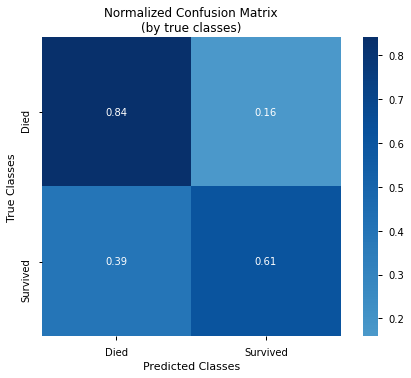

In [28]:
## Putting it all Together
logit = sm.Logit(y_train,X_train_sms).fit()
display(logit.summary())

y_hat_train = logit.predict(X_train_sms).round()
y_hat_test = logit.predict(X_test_sms).round()
evaluate_statsmodel(y_test,y_hat_test)

Optimization terminated successfully.
         Current function value: 0.422151
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  511
Model:                          Logit   Df Residuals:                      503
Method:                           MLE   Df Model:                            7
Date:                Wed, 02 Sep 2020   Pseudo R-squ.:                  0.3603
Time:                        17:48:40   Log-Likelihood:                -215.72
converged:                       True   LL-Null:                       -337.22
Covariance Type:            nonrobust   LLR p-value:                 8.564e-49
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4746      0.329      4.475      0.000       0.829       2.120
Pclass        -1.0147      0.165     -6.148      0.000      -1.338      -0.691
Age           -0.6972      0.144     -4.854      0.000      -0.979      -0.416
SibSp         -0.2736      0.140     -1.948      0.051      -0.549       0.002
Fare          -0.0272      0.140     -0.195      0.846      -0.301       0.247
Sex_male      -2.7507      0.265    -10.399      0.000      -3.269      -2.232
Embarked_Q    -1.6988      0.793     -2.143      0.032      -3.253      -0.145
Embarked_S    -0.4827      0.322     -1.497      0.134      -1.115       0.149
==============================================================================
"""

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

        Died       0.71      0.84      0.77        88
    Survived       0.77      0.61      0.68        77

    accuracy                           0.73       165
   macro avg       0.74      0.73      0.73       165
weighted avg       0.74      0.73      0.73       165

------------------------------------------------------------


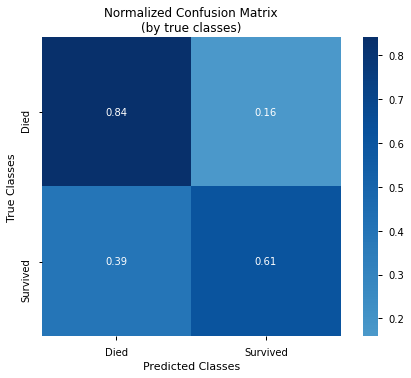

In [29]:
## Putting it all Together
logit = sm.Logit(y_train,X_train_sms).fit()
display(logit.summary())

y_hat_train = logit.predict(X_train_sms).round()
y_hat_test = logit.predict(X_test_sms).round()
evaluate_statsmodel(y_test,y_hat_test)

In [30]:
# logit.params

In [31]:
get_model_coeffs(X_train_sms,logit)

,Coefficents,p-values
const,1.474566,0.0000
Pclass,-1.014705,0.0000
Age,-0.697198,0.0000
SibSp,-0.273558,0.0514
Fare,-0.027249,0.8456
Sex_male,-2.750685,0.0000
Embarked_Q,-1.698832,0.0321
Embarked_S,-0.482682,0.1344


# NEW -  Logistic Regression with `sklearn`


## Fitting a Logistic Regression with `sklearn`

> A note on hyperparameters:
- C 
- solver
- intercept

In [69]:
from sklearn.linear_model import LogisticRegression

## Fit a logistic regression model with defaults
log_reg = LogisticRegression()#
log_reg.fit(X_train_sca, y_train)

LogisticRegression()

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

        Died       0.73      0.85      0.79        88
    Survived       0.79      0.64      0.71        77

    accuracy                           0.75       165
   macro avg       0.76      0.74      0.75       165
weighted avg       0.76      0.75      0.75       165

------------------------------------------------------------


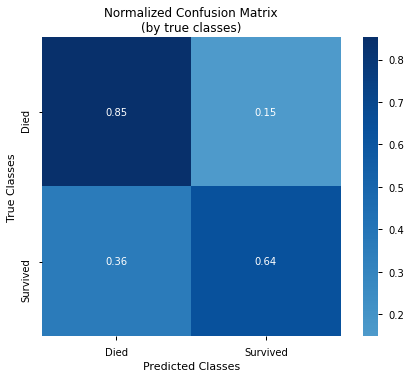

In [70]:
## Get Predictions for training and test data
y_hat_train = log_reg.predict(X_train_sca)
y_hat_test = log_reg.predict(X_test_sca)

## Use our evaluation function
evaluate_statsmodel(y_test,y_hat_test)

In [76]:
## Get the coefficents from the model and make into a series
pd.Series(log_reg.coef_[0],index=X_train_sca.columns)

Pclass       -0.974664
Age          -0.663669
SibSp        -0.249112
Fare         -0.001604
Sex_male     -2.542206
Embarked_Q   -1.028963
Embarked_S   -0.364697
dtype: float64

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

        Died       0.71      0.84      0.77        88
    Survived       0.77      0.61      0.68        77

    accuracy                           0.73       165
   macro avg       0.74      0.73      0.73       165
weighted avg       0.74      0.73      0.73       165

------------------------------------------------------------


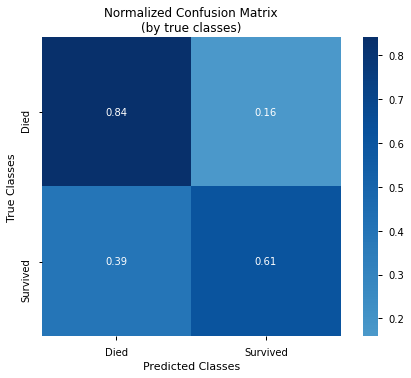

In [77]:
## Fit a logistic regression model with C=1e5, solver='liblinear'
log_reg = LogisticRegression(C=1e5, solver='liblinear')
log_reg.fit(X_train_sca, y_train)


y_hat_train = log_reg.predict(X_train_sca)
y_hat_test = log_reg.predict(X_test_sca)


evaluate_statsmodel(y_test,y_hat_test)

# ROC Curve - Receiver Operating Characteristic Curve

## Evaluating Our Model

### Graph Interpretation

False Positive Rate vs True Positive Rate → for each threshold

<img src="https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/roc_comparison.png" width=70%>

### Looking at Just the Logistic Regression

Imagine we have a logistic regression (classifier):
 - Turn a continuous feature to binary prediction

### What Distributions Would Work Well in Classifying?

<img src="https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/roc_crossover.png" width=60%>

### Defining the Threshold

<img src="https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/auc_rates.png" width=60%>

In [39]:
# # Interactive ROC curve
# from IPython.display import IFrame
# IFrame('http://www.navan.name/roc/', width=900, height=600)

In [78]:
import sklearn.metrics 

# Scikit-learn's built in roc_curve method returns the fpr, tpr, and thresholds
# for various decision boundaries given the case member probabilites

## Get y_score or y_score_prob from the log_reg decision function / predict proba
y_score = log_reg.decision_function(X_test_sca)
y_score_prob = log_reg.predict_proba(X_test_sca)

y_score.shape, y_score_prob.shape

((165,), (165, 2))

In [79]:
## Calculate the FP rate and TP rate
fpr,tpr,thresh = metrics.roc_curve(y_test,y_score)

## calculate area under the curve
print(f"ROC-area-under-the-curve= {round(metrics.auc(fpr,tpr),3)}")

ROC-area-under-the-curve= 0.826


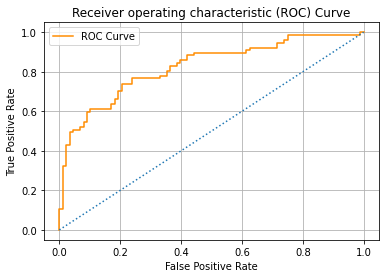

In [80]:
## Plot The ROC Curve
fig,ax=plt.subplots()

## PLot fpt vs tpr
ax.plot(fpr,tpr,color='darkorange',label='ROC Curve')

## Plot a diagnonal line to indicate worthless model
ax.plot([0,1],[0,1],ls=':',label='worthless')


## Properly Label axes and title figure
ax.set(ylabel='True Positive Rate',xlabel='False Positive Rate',
      title='Receiver operating characteristic (ROC) Curve')

## Add legend and grid
ax.legend()
ax.grid()

ROC-area-under-the-curve= 0.826


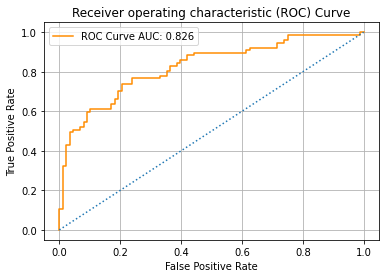

In [81]:
def plot_roc_curve(y_test,y_score):
    # y_score = regr.decision_function(X_test)
    fpr,tpr,thresh = metrics.roc_curve(y_test,y_score)
    AUC = round(metrics.auc(fpr,tpr),3)
    print(f"ROC-area-under-the-curve= {AUC}")

    fig,ax=plt.subplots()
    ax.plot(fpr,tpr,color='darkorange',label=f'ROC Curve AUC: {AUC}')
    ax.plot([0,1],[0,1],ls=':')
    
    ax.set(ylabel='True Positive Rate',xlabel='False Positive Rate',
          title='Receiver operating characteristic (ROC) Curve')

    
    ax.legend()
    ax.grid()

    
plot_roc_curve(y_test,y_score)

### But now there's a sklearn tool for that!

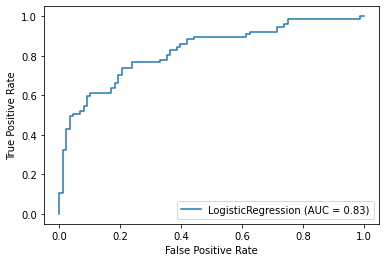

In [82]:
metrics.plot_roc_curve(log_reg,X_test_sca,y_test)

Text(0.5, 1.0, 'Receiving Operator Characteristic (ROC) Curve')

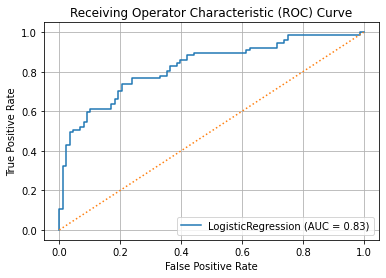

In [83]:
## Update the sklearn plot to include the diagonal line and grid
roc_plot = metrics.plot_roc_curve(log_reg, X_test_sca, y_test,)
ax= roc_plot.ax_

ax.plot([0,1],[0,1],ls=':')

ax.grid()
ax.set_title('Receiving Operator Characteristic (ROC) Curve')

# Activity: Make an `evaluate_classification` function

- Write a function called `evaluate_classification`
- It should accept (at minimum): 
    - model (sklearn model)
    - X_test
    - y_test
    
- ***Ideally you should also accept X_train and y_train to compare results to check for overfitting. ?***
- It should produce:
    - Classification metrics printed
    - Confusion Matrix displayed
    - roc_auc curve displayed
    
    
- Then revisit some of the questions we had from last class re: scaling, LogisticRegression parameters

In [64]:
import sklearn.metrics as metrics

def evaluate_classification(model,X_test,y_test,classes=None,
                           normalize='true',cmap='Purples',label=''): 
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"

    if len(label)>0:
        table_header += f" {label}"
        
    ## PRINT TABLE
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')
    print(metrics.classification_report(y_test,y_hat_test,
                                        target_names=classes))    
    print(dashes+"\n\n")
    
    
    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Roc Curve
    roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()
    
    return fig,ax

------------------------------------------------------------
[i] CLASSIFICATION REPORT {'C': 100000.0, 'solver': 'liblinear'}
------------------------------------------------------------
              precision    recall  f1-score   support

        Died       0.71      0.84      0.77        88
    Survived       0.77      0.61      0.68        77

    accuracy                           0.73       165
   macro avg       0.74      0.73      0.73       165
weighted avg       0.74      0.73      0.73       165

------------------------------------------------------------




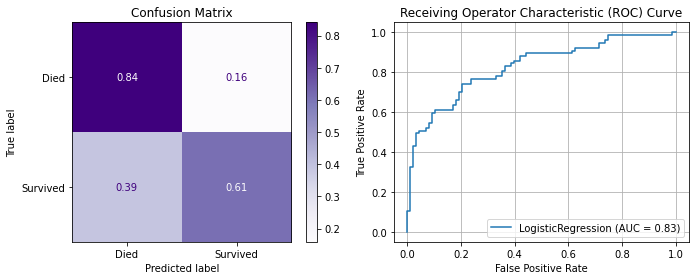

In [84]:
## Fit and evaluate a logistic regression 
params  = dict(C=1e5, solver='liblinear')
log_reg = LogisticRegression(**params)
log_reg.fit(X_train_sca, y_train)

evaluate_classification(log_reg,X_test_sca,y_test,
                        classes=['Died','Survived'],label=str(params));

# Hyperparameter Tuning: GridSearchCV 

### `solver` Parameter
https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

- The solvers implemented in the class LogisticRegression are “liblinear”, “newton-cg”, “lbfgs”, “sag” and “saga”:

- The solver “liblinear” uses a coordinate descent (CD) algorithm, and relies on the excellent C++ LIBLINEAR library, which is shipped with scikit-learn. However, the CD algorithm implemented in liblinear cannot learn a true multinomial (multiclass) model; instead, the optimization problem is decomposed in a “one-vs-rest” fashion so separate binary classifiers are trained for all classes. This happens under the hood, so LogisticRegression instances using this solver behave as multiclass classifiers.





In [85]:
1000,10**3, 1e3

(1000, 1000, 1000.0)

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [104]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
model = LogisticRegression(solver='liblinear')

params = {'C' : [1.0,5,10,20,100,1e5,1e10,1e16]}

gridsearch = GridSearchCV(model,params,scoring='recall',return_train_score=True)
gridsearch.fit(X_train_sca,y_train)

print('BEST RESULTS:')
print(gridsearch.best_score_)
gridsearch.best_params_

BEST RESULTS:
0.7105263157894737


{'C': 10}

In [105]:
grid_results = pd.DataFrame(gridsearch.cv_results_)
grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003214,0.000119,0.002832,0.000331,1,{'C': 1.0},0.657895,0.842105,0.605263,0.684211,...,0.700000,0.079123,8,0.723684,0.664474,0.730263,0.717105,0.710526,0.709211,0.023316
1,0.003348,0.000185,0.002740,0.000090,5,{'C': 5},0.684211,0.842105,0.605263,0.684211,...,0.705263,0.076993,7,0.723684,0.677632,0.730263,0.717105,0.717105,0.713158,0.018421
2,0.003172,0.000049,0.002713,0.000159,10,{'C': 10},0.684211,0.842105,0.605263,0.684211,...,0.710526,0.078065,1,0.730263,0.671053,0.730263,0.717105,0.717105,0.713158,0.021860
3,0.003403,0.000181,0.002870,0.000237,20,{'C': 20},0.684211,0.842105,0.605263,0.684211,...,0.710526,0.078065,1,0.730263,0.671053,0.730263,0.717105,0.717105,0.713158,0.021860
4,0.003221,0.000229,0.002695,0.000160,100,{'C': 100},0.684211,0.842105,0.605263,0.684211,...,0.710526,0.078065,1,0.730263,0.677632,0.730263,0.717105,0.717105,0.714474,0.019338
5,0.003151,0.000123,0.002569,0.000045,100000,{'C': 100000.0},0.684211,0.842105,0.605263,0.684211,...,0.710526,0.078065,1,0.730263,0.677632,0.730263,0.717105,0.710526,0.713158,0.019338
6,0.003498,0.000314,0.002800,0.000061,1e+10,{'C': 10000000000.0},0.684211,0.842105,0.605263,0.684211,...,0.710526,0.078065,1,0.730263,0.677632,0.730263,0.717105,0.710526,0.713158,0.019338
7,0.003098,0.000049,0.002567,0.000084,1e+16,{'C': 1e+16},0.684211,0.842105,0.605263,0.684211,...,0.710526,0.078065,1,0.730263,0.677632,0.730263,0.717105,0.710526,0.713158,0.019338


<AxesSubplot:xlabel='param_C'>

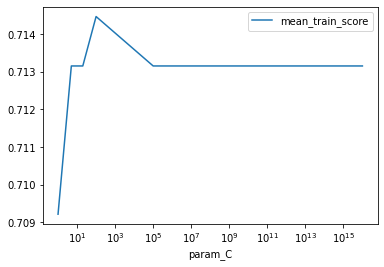

In [107]:
grid_results.plot('param_C','mean_train_score',logx=True)

In [108]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
model = LogisticRegression()

params = {'C' : [0.01,0.1,1.0,10,100,1e5],
          'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
          'solver':["liblinear", "newton-cg", "lbfgs", "sag","saga"],
          'fit_intercept':[True,False],
          'class_weight':[None,'balanced']
         }

gridsearch = GridSearchCV(model,params,scoring='roc_auc',return_train_score=True)
gridsearch.fit(X_train_sca,y_train)

print('BEST RESULTS:')
print(gridsearch.best_score_)
gridsearch.best_params_

BEST RESULTS:
0.8604175101214576


{'C': 10,
 'class_weight': None,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [109]:
best_params = gridsearch.best_params_
best_params

{'C': 10,
 'class_weight': None,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'newton-cg'}

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        88
           1       0.77      0.61      0.68        77

    accuracy                           0.73       165
   macro avg       0.74      0.73      0.73       165
weighted avg       0.74      0.73      0.73       165

------------------------------------------------------------




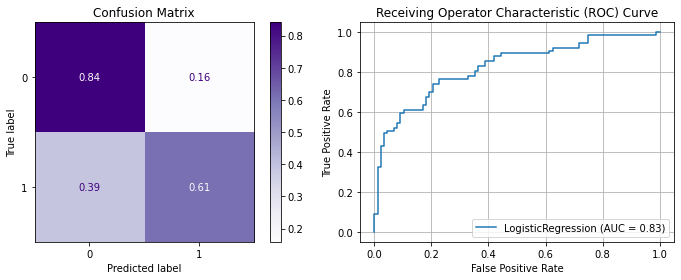

(<Figure size 720x288 with 3 Axes>,
 <AxesSubplot:title={'center':'Receiving Operator Characteristic (ROC) Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

In [110]:
best_model = LogisticRegression(**best_params)
best_model.fit(X_train_sca,y_train)
evaluate_classification(best_model,X_test_sca,y_test)

In [111]:
grid_results = pd.DataFrame(gridsearch.cv_results_)
grid_results.sort_values('mean_train_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_fit_intercept,param_penalty,param_solver,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003605,0.000488,0.003476,0.000190,0.01,None,True,l1,liblinear,"{'C': 0.01, 'class_weight': None, 'fit_interce...",...,0.5,0.0,257,0.5,0.5,0.5,0.5,0.5,0.5,0.0
4,0.003840,0.000255,0.003344,0.000406,0.01,None,True,l1,saga,"{'C': 0.01, 'class_weight': None, 'fit_interce...",...,0.5,0.0,257,0.5,0.5,0.5,0.5,0.5,0.5,0.0
64,0.003455,0.000080,0.002652,0.000014,0.01,balanced,False,l1,saga,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",...,0.5,0.0,257,0.5,0.5,0.5,0.5,0.5,0.5,0.0
60,0.002745,0.000022,0.002652,0.000023,0.01,balanced,False,l1,liblinear,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",...,0.5,0.0,257,0.5,0.5,0.5,0.5,0.5,0.5,0.0
44,0.003486,0.000086,0.002636,0.000025,0.01,balanced,True,l1,saga,"{'C': 0.01, 'class_weight': 'balanced', 'fit_i...",...,0.5,0.0,257,0.5,0.5,0.5,0.5,0.5,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,0.000560,0.000010,0.000000,0.000000,100000,balanced,False,elasticnet,newton-cg,"{'C': 100000.0, 'class_weight': 'balanced', 'f...",...,NaN,NaN,316,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472,0.000614,0.000054,0.000000,0.000000,100000,balanced,False,elasticnet,lbfgs,"{'C': 100000.0, 'class_weight': 'balanced', 'f...",...,NaN,NaN,317,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473,0.000540,0.000035,0.000000,0.000000,100000,balanced,False,elasticnet,sag,"{'C': 100000.0, 'class_weight': 'balanced', 'f...",...,NaN,NaN,318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474,0.000545,0.000029,0.000000,0.000000,100000,balanced,False,elasticnet,saga,"{'C': 100000.0, 'class_weight': 'balanced', 'f...",...,NaN,NaN,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Class Imbalance

## Class Imbalance Problems Lab

In [123]:
# !pip install -U imblearn

In [116]:
df = pd.read_csv('../creditcard.csv.gz')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [129]:
target = 'Class'
y = df[target].copy()
X = df.drop(columns=target).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

y_train.value_counts(1)

0    0.998258
1    0.001742
Name: Class, dtype: float64

### When metrics can be misleading...
- i.e. accuracy


In [137]:
# from sklearn
regr = LogisticRegression(fit_intercept=False, solver='liblinear')
regr.fit(X_train, y_train)

regr.score(X_test,y_test)

0.9984691441251651

> ### Woohoo! We must have an amazing model!!...

------------------------------------------------------------
[i] CLASSIFICATION REPORT Imbalanced
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.54      0.56      0.55       120

    accuracy                           1.00     71202
   macro avg       0.77      0.78      0.78     71202
weighted avg       1.00      1.00      1.00     71202

------------------------------------------------------------




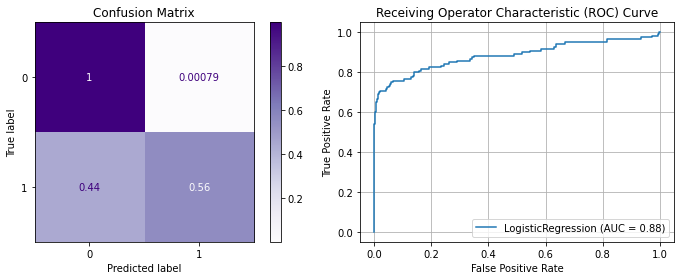

In [138]:
evaluate_classification(regr,X_test, y_test,label='Imbalanced');

In [140]:
y_test.value_counts(normalize=True)

0    0.998315
1    0.001685
Name: Class, dtype: float64

### DummyClassifier for Dummies

In [145]:
from sklearn.dummy import DummyClassifier

## Let's guess 0 for every observation
dummy = DummyClassifier(strategy='constant',constant=0)

preds = dummy.fit(X_train,y_train).predict(X_test)

## How did we do?
dummy.score(X_test,y_test)

0.9983146540827504

------------------------------------------------------------
[i] CLASSIFICATION REPORT Dummy
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.00      0.00      0.00       120

    accuracy                           1.00     71202
   macro avg       0.50      0.50      0.50     71202
weighted avg       1.00      1.00      1.00     71202

------------------------------------------------------------




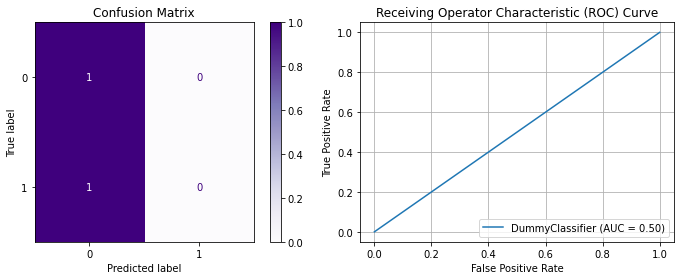

In [172]:
evaluate_classification(dummy,X_test, y_test,label='Dummy');

> So what can we do?

## The Possible Solutions

- Using `class_weight` parameter 
- Oversampling the minority class
- Undersampling the majority class

------------------------------------------------------------
[i] CLASSIFICATION REPORT BASELINE
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.54      0.56      0.55       120

    accuracy                           1.00     71202
   macro avg       0.77      0.78      0.78     71202
weighted avg       1.00      1.00      1.00     71202

------------------------------------------------------------




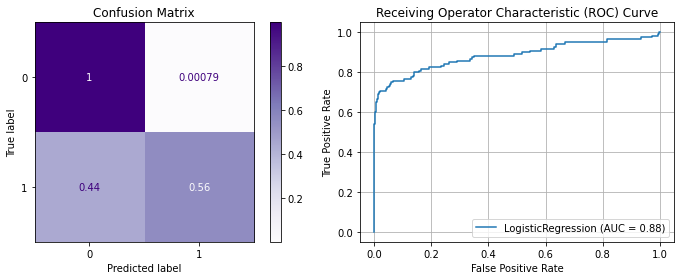

{'fit_intercept': False, 'solver': 'liblinear'}


In [173]:
## Baseline Model using lesson paras
params = dict(fit_intercept=False, solver='liblinear')
regr = LogisticRegression(**params)
regr.fit(X_train, y_train)
evaluate_classification(regr,X_test,y_test,label="BASELINE" )
print(params)#str(params))

### Solution 1: `class_weight="balanced"`


------------------------------------------------------------
[i] CLASSIFICATION REPORT balanced
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71082
           1       0.05      0.91      0.09       120

    accuracy                           0.97     71202
   macro avg       0.52      0.94      0.54     71202
weighted avg       1.00      0.97      0.98     71202

------------------------------------------------------------




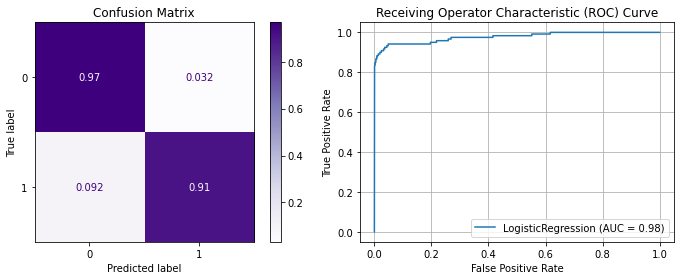

(<Figure size 720x288 with 3 Axes>,
 <AxesSubplot:title={'center':'Receiving Operator Characteristic (ROC) Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

In [174]:
regr = LogisticRegression(class_weight='balanced',**params)
regr.fit(X_train, y_train)
evaluate_classification(regr,X_test,y_test,label='balanced')

### Solution 2: Oversampling minority class with SMOTE

In [175]:
y_train.value_counts(0)

0    213233
1       372
Name: Class, dtype: int64

In [176]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_sample(X_train,y_train)
pd.Series(y_train_smote).value_counts()

1    213233
0    213233
Name: Class, dtype: int64

------------------------------------------------------------
[i] CLASSIFICATION REPORT SMOTE
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71082
           1       0.07      0.88      0.13       120

    accuracy                           0.98     71202
   macro avg       0.53      0.93      0.56     71202
weighted avg       1.00      0.98      0.99     71202

------------------------------------------------------------




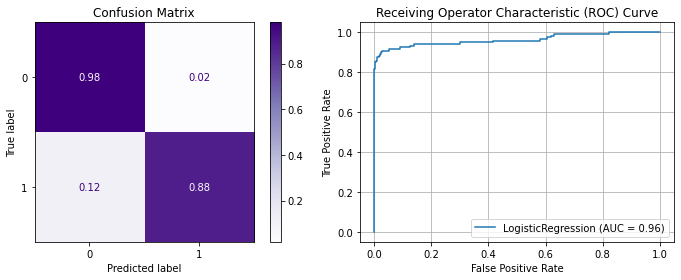

(<Figure size 720x288 with 3 Axes>,
 <AxesSubplot:title={'center':'Receiving Operator Characteristic (ROC) Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

In [177]:
regr = LogisticRegression(**params)#class_weight='balanced',C=1e5, solver='liblinear')
regr.fit(X_train_smote, y_train_smote)
evaluate_classification(regr,X_test,y_test,label='SMOTE')

### Solution 3: Undersampling majority class

In [178]:
df_balance = pd.concat([X_train, y_train],axis=1)
df_balance

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
194763,130747.0,2.047163,0.107987,-1.806515,0.072733,0.248371,-1.744837,0.712448,-0.488842,-0.102709,...,0.241017,0.822618,0.023000,0.549868,0.322173,0.191755,-0.085025,-0.084292,0.77,0
135660,81344.0,1.282404,0.459864,-0.372286,0.826375,0.463568,-0.466407,0.460867,-0.186469,-0.549700,...,0.013986,0.083896,-0.247504,-0.325527,0.927293,-0.272555,-0.010168,-0.005332,1.79,0
259186,159004.0,-0.414863,0.012026,1.356386,1.107374,0.813456,-0.156497,-0.372675,0.031095,-0.100143,...,-0.052272,-0.088160,0.062521,-0.680805,-0.641474,-0.159995,0.237628,0.204343,5.95,0
87387,61662.0,-1.432948,1.478076,0.576724,0.207540,-0.670662,-0.464572,0.221023,-0.099811,1.561896,...,-0.055014,0.364330,0.154670,0.635611,-0.366314,0.163690,-0.750285,-0.275117,9.20,0
267282,162703.0,2.051016,-0.016765,-2.284865,0.302168,0.786895,-0.998558,0.768990,-0.464383,0.362863,...,0.133331,0.491780,-0.119020,0.527179,0.607105,-0.090453,-0.065787,-0.062680,47.53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211543,138459.0,-1.321976,1.138686,-0.940861,0.154160,0.109802,-0.538822,0.490058,0.513762,-0.493834,...,-0.012778,-0.237503,0.008713,-0.767844,-0.397162,0.316379,-0.463125,-0.010589,49.89,0
86293,61167.0,-0.627810,0.918729,1.478453,0.213171,0.933695,1.261486,0.504752,0.404286,-0.939740,...,-0.051356,-0.004245,0.090535,-0.964599,-0.522294,0.296733,0.145939,0.110400,24.99,0
122579,76616.0,1.512602,-0.949435,-0.219062,-1.638850,-0.856348,-0.465996,-0.669193,-0.135566,-2.284345,...,-0.558803,-1.377240,0.080444,-0.579511,0.297851,-0.495367,-0.001415,0.003665,34.90,0
152315,97253.0,1.798863,-1.699791,-0.142182,-0.619533,-1.570248,0.083268,-1.501980,0.176287,1.755507,...,0.181914,0.351358,0.115638,-0.566188,-0.596200,-0.295152,-0.033616,-0.032471,171.31,0


In [179]:
n_samples = df_balance['Class'].value_counts().min()
n_samples

372

In [180]:
df_balance.groupby('Class').groups

{0: [194763, 135660, 259186, 87387, 267282, 264314, 73653, 279935, 138560, 257460, 68126, 247403, 266224, 224404, 150946, 246192, 62971, 195047, 236277, 103903, 264638, 153129, 11727, 15635, 115187, 275343, 251577, 241619, 103900, 89148, 141826, 42076, 36931, 228539, 118040, 50446, 105645, 186805, 100546, 58526, 164450, 100536, 11962, 86732, 56040, 177041, 250495, 15046, 190705, 24852, 126703, 134266, 102756, 120707, 175560, 201588, 223323, 67486, 5124, 258521, 228291, 48143, 185006, 119187, 102724, 36243, 236299, 24772, 168482, 36030, 34341, 153467, 47322, 162907, 178791, 65916, 6260, 119862, 245195, 253166, 224701, 11045, 177641, 276182, 224409, 77579, 179387, 16938, 58453, 203308, 104967, 244692, 190513, 100137, 6550, 160708, 150952, 79830, 82402, 22296, ...], 1: [53794, 42784, 149869, 17366, 157585, 128479, 6472, 251891, 152019, 235616, 213092, 150667, 237107, 6719, 68633, 144104, 47802, 10204, 272521, 88258, 6329, 274382, 150647, 15781, 153823, 241254, 9179, 41569, 280143, 222419,

In [181]:
df_resample = pd.DataFrame()
for grp,idx in df_balance.groupby('Class').groups.items():
    
    resample = df_balance.loc[idx].sample(n=n_samples,random_state=123)
    df_resample = pd.concat([df_resample,resample],axis=0)
    
display(df_resample.head(), df_resample["Class"].value_counts())



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
230178,146225.0,-1.471584,1.048034,-0.121530,0.294235,1.008532,6.129592,-3.153504,-1.929004,1.661659,...,4.157237,0.048731,0.680405,0.668165,-1.277351,-0.467549,0.527242,0.278444,1.00,0
247695,153661.0,2.096084,-1.376627,0.194561,-0.715901,-1.553168,0.431772,-1.763065,0.331340,0.865917,...,0.151258,0.704155,0.173941,-0.470474,-0.324661,-0.177678,0.055154,-0.053309,3.20,0
204626,135369.0,1.863445,-0.981573,-0.694210,-0.857710,-0.806651,-0.232154,-0.772867,0.156154,1.461948,...,0.261563,0.644129,0.164242,0.746726,-0.436316,0.651170,-0.064889,-0.045237,80.10,0
13793,24459.0,-0.888568,1.220439,1.253009,0.741607,0.414096,-0.072251,1.186912,-0.623745,1.231374,...,-0.152703,0.387293,-0.174805,-0.045627,-0.214310,-0.434546,-0.184802,-0.165824,61.81,0
244902,152535.0,1.973384,-0.235705,-0.453193,0.238827,-0.313211,-0.236997,-0.408025,-0.007399,0.809414,...,-0.187040,-0.377358,0.318120,-0.426956,-0.378039,-0.662360,0.033402,-0.043114,7.81,0


1    372
0    372
Name: Class, dtype: int64

------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     71082
           1       0.04      0.93      0.07       120

    accuracy                           0.96     71202
   macro avg       0.52      0.94      0.53     71202
weighted avg       1.00      0.96      0.98     71202

------------------------------------------------------------




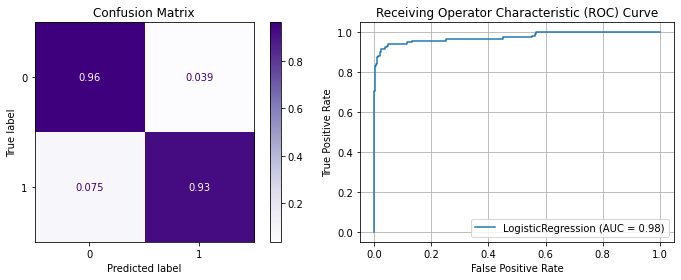

(<Figure size 720x288 with 3 Axes>,
 <AxesSubplot:title={'center':'Receiving Operator Characteristic (ROC) Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

In [182]:
X_train_under = df_resample.drop('Class',axis=1).copy()
y_train_under = df_resample['Class'].copy()

regr = LogisticRegression(**params)#C=1e5, solver='liblinear')
regr.fit(X_train_under, y_train_under)
evaluate_classification(regr,X_test,y_test)

# Sect 26: Topics to Discuss

- Recommendation: do not get too stressed out about that this module. Its a lot of revisiting concepts that we've discussed before. 
    - Don't stress about the labs, look at the solutions and digest what they are doing.
    
- [Terms to remember](https://learn.co/tracks/module-3-data-science-career-2-1/machine-learning/section-26-in-depth-logistic-regression/mle-review)
    - "log-likelihood"
    - "Maximum Likelihood Estimation"

# APPENDIX

In [ ]:
## Trying out class balances with different seeds
# seed_results = []
# for seed in range(321):
#     X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=seed)
#     percent_class_1 =  y_train.value_counts(1).loc[1]
#     seed_results.append({'seed':seed, 'value_counts':percent_class_1})

# pd.DataFrame.from_records(seed_results).sort_values('value_counts').head()

### Faster GridSearches with Tune Sklearn
https://towardsdatascience.com/5x-faster-scikit-learn-parameter-tuning-in-5-lines-of-code-be6bdd21833c

In [ ]:
# # !pip install scikit-optimize
# !pip install tune-sklearn
# !pip install tune-sklearn ray[tune]

In [ ]:
# from tune_sklearn import TuneGridSearchCV

# model = LogisticRegression()

# params = {'C' : [0.01,0.1,1.0,10,100,1e5],
#           'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#           'solver':["liblinear", "newton-cg", "lbfgs", "sag","saga"],
#           'fit_intercept':[True,False],
#           'class_weight':[None,'balanced']
#          }

# gridsearch = TuneGridSearchCV(model,params,scoring='roc_auc',return_train_score=True)
# gridsearch.fit(X_train_sca,y_train)

# print('BEST RESULTS:')
# print(gridsearch.best_score_)
# gridsearch.best_params_